# Data Analysis of the Ford GoBike's trip data
The public trip data of bike rides.


[The Data](https://www.fordgobike.com/system-data)  
Each trip is anonymized and includes:
* Trip Duration (seconds)
* Start Time and Date
* End Time and Date
* Start Station ID
* Start Station Name
* Start Station Latitude
* Start Station Longitude
* End Station ID
* End Station Name
* End Station Latitude
* End Station Longitude
* Bike ID
* User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)
* Member Year of Birth
* Member Gender
* [Bike Share For All Trip](https://www.fordgobike.com/pricing/bikeshareforall)



In [4]:
import requests
import os, sys
import re
import pandas as pd
import numpy as np
import zipfile
import json
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
DOWNLOADS_DIR = 'downloads'
DATA_DIR = 'data'
IMAGES_DIR = 'images'

def ensure_dir(file_path=DOWNLOADS_DIR):
    """
    Ensure directory exists or create it.
    :param file_path: directory path
    :return: 
    """
    if not os.path.exists(file_path):
        os.makedirs(file_path)

        
def download(*urls):
    """
    Download files from the provided URL.
    :param urls: variable number of URL
    :return: None
    """
    ensure_dir()
    for url in urls:
        url_file = os.path.join(DOWNLOADS_DIR, url.split(os.path.sep)[-1]).replace('-', '_')
        if not os.path.exists(url_file):
            response = requests.get(url, allow_redirects=True)
            with open(url_file, 'wb') as handle:
                handle.write(response.content)
                sys.stdout.write('.')
    sys.stdout.write('\n')


def download_img(name, url):
    """
    Download image from the provided URL
    :param name: name of image file
    :param url: URL for image
    :return: None
    """
    ensure_dir(IMAGES_DIR)
    image_file = os.path.join(IMAGES_DIR, f"{name}.{url.split('.')[-1]}")
    if not os.path.exists(image_file):
        response = requests.get(url, allow_redirects=True)
        with open(image_file, 'wb') as handle:
            handle.write(response.content)


def extract_zip(file, path=DATA_DIR):
    """
    Extract alla files from a zip archive.
    :param file: file name of archive.
    :param path: target directory for unzipped files.
    :return: a list of file names in the archive.
    """
    with zipfile.ZipFile(os.path.join(DOWNLOADS_DIR, file), 'r') as zip_ref:
        zip_ref.extractall(path)
        return zip_ref.namelist()

def rename(file_from, file_to, directory=DOWNLOADS_DIR):
    """
    Rename file in the 
    :param file_from: Existing file to rename
    :param file_to: Target file name
    :param directory: Source directory, defaults to DOWNLOADS_DIR
    :return: None
    """
    source = os.path.join(directory, file_from)
    if os.path.exists(source):
        os.rename(source, os.path.join(directory, file_to))


def file_exists(filename, directory=DOWNLOADS_DIR):
    """
    Check if the file exists in a optional provided directory.
    :param filename: name of file
    :param directory: Source directory, defaults to DOWNLOADS_DIR
    :return: True if file exists.
    """
    return os.path.exists(os.path.join(directory, filename))

## Gather

In [19]:
download('https://s3.amazonaws.com/fordgobike-data/201801-fordgobike-tripdata.csv.zip', 
        'https://s3.amazonaws.com/fordgobike-data/201802-fordgobike-tripdata.csv.zip', 
        'https://s3.amazonaws.com/fordgobike-data/201803-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201804-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201805-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201806-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201807-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201808-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201809-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201810-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201811-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201812-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201901-fordgobike-tripdata.csv.zip',
        'https://s3.amazonaws.com/fordgobike-data/201902-fordgobike-tripdata.csv.zip')

..............


In [20]:
for file in os.listdir(DOWNLOADS_DIR):
    print(file)

201801_fordgobike_tripdata.csv.zip
201812_fordgobike_tripdata.csv.zip
201804_fordgobike_tripdata.csv.zip
201805_fordgobike_tripdata.csv.zip
201901_fordgobike_tripdata.csv.zip
201809_fordgobike_tripdata.csv.zip
201902_fordgobike_tripdata.csv.zip
201803_fordgobike_tripdata.csv.zip
201810_fordgobike_tripdata.csv.zip
201806_fordgobike_tripdata.csv.zip
201808_fordgobike_tripdata.csv.zip
201811_fordgobike_tripdata.csv.zip
201807_fordgobike_tripdata.csv.zip
201802_fordgobike_tripdata.csv.zip


In [22]:
zip_files = [file for file in os.listdir(DOWNLOADS_DIR) if file.endswith('.zip') and os.path.isfile(os.path.join(DOWNLOADS_DIR, file))]

In [23]:
for file in zip_files:
    extract_zip(file, DATA_DIR)
for file in os.listdir(DATA_DIR):
    print(file)

201802-fordgobike-tripdata.csv
201811-fordgobike-tripdata.csv
201809-fordgobike-tripdata.csv
201806-fordgobike-tripdata.csv
201805-fordgobike-tripdata.csv
201812-fordgobike-tripdata.csv
201801-fordgobike-tripdata.csv
201901-fordgobike-tripdata.csv
201807-fordgobike-tripdata.csv
201808-fordgobike-tripdata.csv
201810-fordgobike-tripdata.csv
201803-fordgobike-tripdata.csv
201804-fordgobike-tripdata.csv
201902-fordgobike-tripdata.csv


In [3]:
# load data source files and make one DataFrame
tripdata_files = [file for file in os.listdir(DATA_DIR) if file.endswith('.csv') and os.path.isfile(os.path.join(DATA_DIR, file))]
dataframes = [pd.read_csv(os.path.join(DATA_DIR, file)) for file in tripdata_files]

bikeshare_df = pd.concat(dataframes)
del tripdata_files
del dataframes
bikeshare_df.shape

(2239215, 16)

## Assess

Quality issues in data source
* duration_sec - parse as timestamp
* start_time - parse as datetime
* end_time - parse as datetime
* member_birth_year - seems to be optional and several members are over 100 years old
* user_type - Subscriber or Customer, categorical
* member_gender - Three values + NaN, categorical
* bike_share_for_all_trip - Yes and No, categorical

In [12]:
print('Number of unique values in each column:')
for col in bikeshare_df.columns:
    print(f"{col}: {bikeshare_df[col].nunique()}")

Number of unique values in each column:
duration_sec: 17505
start_time: 2239052
end_time: 2239079
start_station_id: 340
start_station_name: 359
start_station_latitude: 385
start_station_longitude: 386
end_station_id: 340
end_station_name: 359
end_station_latitude: 386
end_station_longitude: 387
bike_id: 6126
user_type: 2
member_birth_year: 89
member_gender: 3
bike_share_for_all_trip: 2
duration_log: 17505


In [42]:
bikeshare_df.isnull().sum()

duration_sec                    0
start_time                      0
end_time                        0
start_station_id            12216
start_station_name          12216
start_station_latitude          0
start_station_longitude         0
end_station_id              12216
end_station_name            12216
end_station_latitude            0
end_station_longitude           0
bike_id                         0
user_type                       0
member_birth_year          128703
member_gender              128349
bike_share_for_all_trip         0
dtype: int64

In [14]:
bikeshare_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2239215 entries, 0 to 183411
Data columns (total 16 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
member_birth_year          float64
member_gender              object
bike_share_for_all_trip    object
dtypes: float64(7), int64(2), object(7)
memory usage: 290.4+ MB


In [47]:
print(f"Customer born in range from min: {bikeshare_df['member_birth_year'].min()} - max: {bikeshare_df['member_birth_year'].dropna().max()}")
bikeshare_df.query("member_birth_year < 1910")['member_birth_year'].value_counts()

Customer born in range from min: 1878.0 - max: 2001.0


1900.0    751
1902.0    192
1901.0     44
1888.0     23
1904.0     12
1881.0      5
1909.0      4
1889.0      3
1906.0      2
1903.0      1
1878.0      1
Name: member_birth_year, dtype: int64

In [5]:
bikeshare_df['user_type'].unique()

array(['Subscriber', 'Customer'], dtype=object)

In [6]:
bikeshare_df['member_gender'].unique()

array(['Male', 'Female', nan, 'Other'], dtype=object)

In [13]:
bikeshare_df['bike_share_for_all_trip'].unique()

array(['No', 'Yes'], dtype=object)

## Clean

Define:
* __start_time__ and __end_time__ parse as datetime
* __duration_sec__ parse as timedelta
* __user_type__ and __bike_share_for_all_trip__ - convert to categorical
* __member_gender__ - NaN replace with role Other, convert to categorical

Code and Test

In [40]:
bikeshare_df['start_time'] = pd.to_datetime(bikeshare_df['start_time'])
bikeshare_df['end_time'] = pd.to_datetime(bikeshare_df['end_time'])
bikeshare_df['duration'] = bikeshare_df['duration_sec'].apply(lambda x: timedelta(seconds=x))

In [41]:
bikeshare_df['user_type'] = bikeshare_df['user_type'].astype('category')
bikeshare_df['bike_share_for_all_trip'] = bikeshare_df['bike_share_for_all_trip'].astype('category')
bikeshare_df['member_gender'].fillna('Other', inplace=True)
bikeshare_df['member_gender'] = bikeshare_df['member_gender'].astype('category')
bikeshare_df['member_gender'].unique()

[Male, Female, Other]
Categories (3, object): [Male, Female, Other]

In [9]:
bikeshare_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2239215 entries, 0 to 183411
Data columns (total 17 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  category
member_birth_year          float64
member_gender              category
bike_share_for_all_trip    category
duration                   timedelta64[ns]
dtypes: category(3), datetime64[ns](2), float64(7), int64(2), object(2), timedelta64[ns](1)
memory usage: 262.7+ MB


## Exploratory Data Analysis

What does the duraction in second distribution look like?

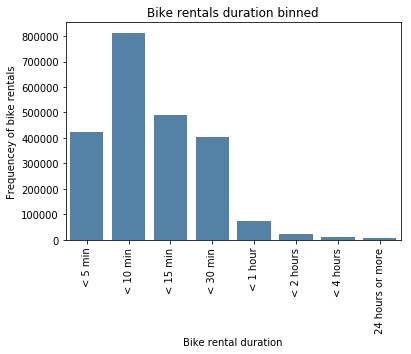

In [20]:
bins = [0, 300, 600, 900, 1800, 3600, 7200, 14400, 86400]
labels = ['< 5 min', '< 10 min', '< 15 min', '< 30 min', '< 1 hour', '< 2 hours', '< 4 hours', '24 hours or more']

duration_quartiles = pd.cut(bikeshare_df['duration_sec'], bins=bins, labels=labels)
binned_duration = duration_quartiles.value_counts(sort=False)
ax = sns.barplot(binned_duration.index, binned_duration, color='steelblue')
ax.set(title='Bike rentals duration binned', xlabel='Bike rental duration', ylabel='Frequencey of bike rentals')
ax.tick_params(axis='x', labelrotation=90)

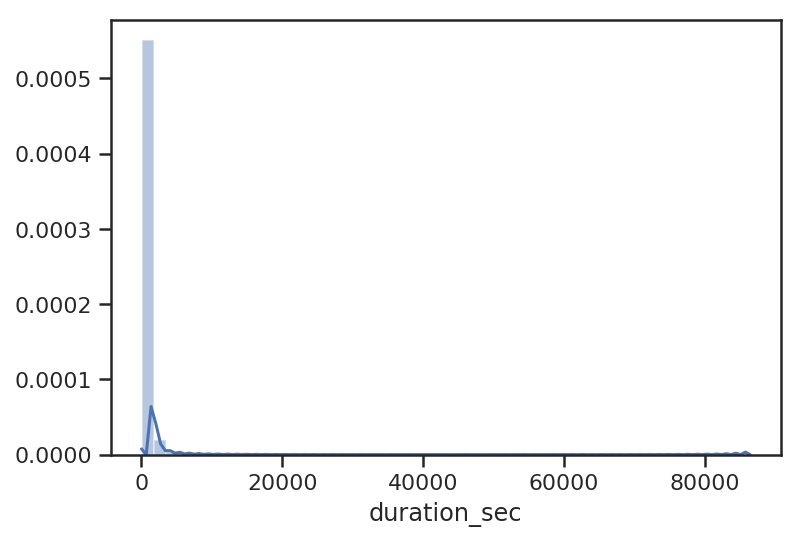

In [11]:
sns.distplot(bikeshare_df['duration_sec']);

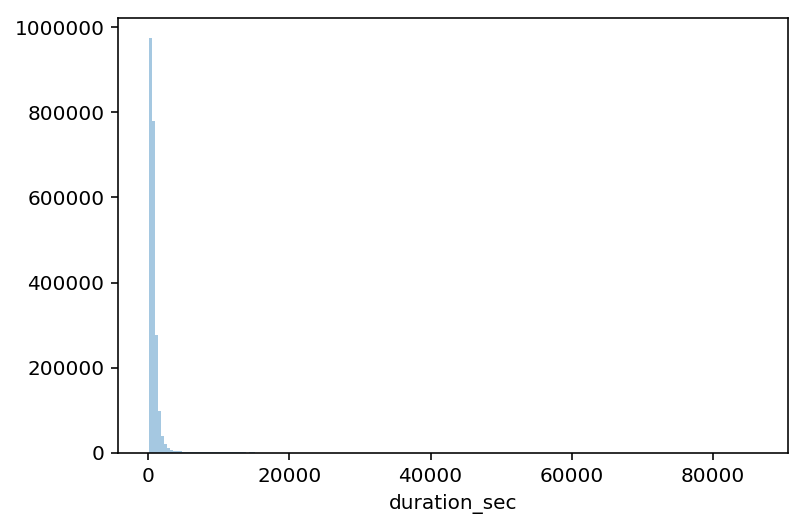

In [4]:
# plot CDF
#plt.hist(bikeshare_df.duration_sec, density=False, cumulative=False);
sns.distplot(bikeshare_df.duration_sec, hist=True, kde=False, bins=200)

In [5]:
confidence = np.percentile(bikeshare_df.duration_sec, [2.5, 97.5])
print(f"95% confidence lower: {confidence[0]} sec - upper: {confidence[1]} sec")

95% confidence lower: 140.0 sec - upper: 2596.0 sec


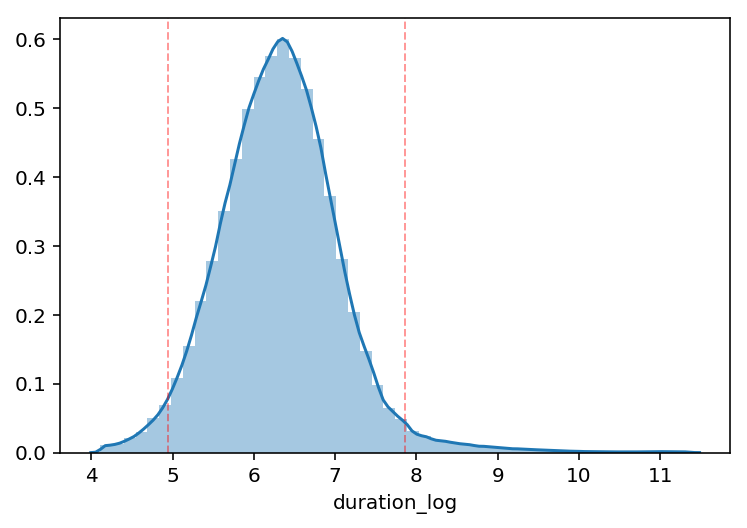

In [6]:
bikeshare_df['duration_log'] = np.log(bikeshare_df.duration_sec)
ax = sns.distplot(bikeshare_df.duration_log)
ax.axvline(x=np.log(confidence[0]), linewidth=1, color='r', linestyle='--', alpha=0.4)
ax.axvline(x=np.log(confidence[1]), linewidth=1, color='r', linestyle='--', alpha=0.4);

In [17]:
sns.palettes.string_types

(str,)

Explore distribution of categorical variables.

1. What is the distribution of user types?
2. What is the distribution of member gender?
3. What is the distribution of bike share for all trip?

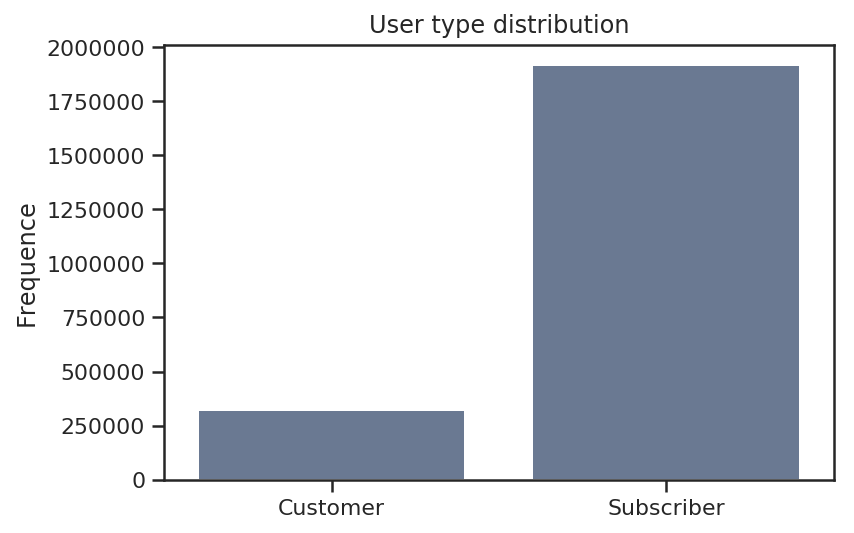

In [29]:
ax = sns.countplot(x='user_type', 
              data=bikeshare_df, 
              hue_order=['Subscriber', 'Customer'], 
              color='b', 
              saturation=0.4)

ax.set(xlabel='', 
       ylabel='Frequence', 
       title='User type distribution');

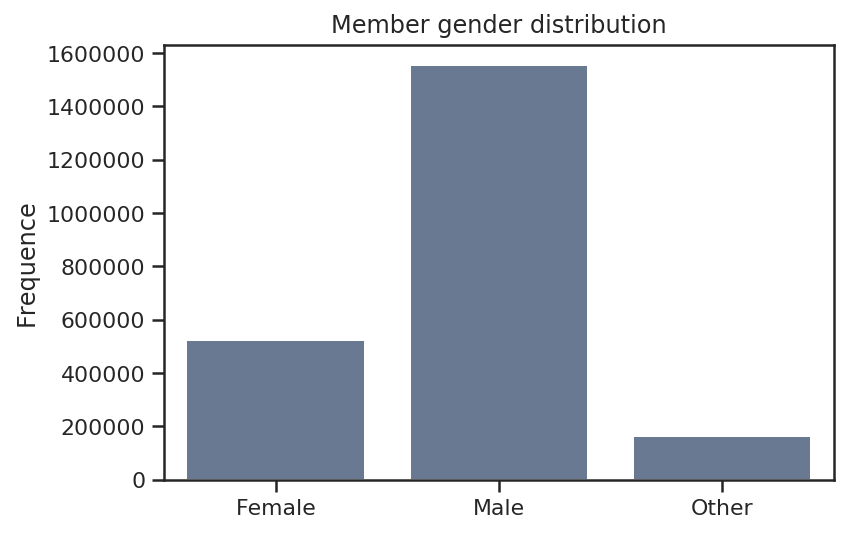

In [30]:
ax = sns.countplot(x='member_gender', 
              data=bikeshare_df, 
              color='b', 
              saturation=0.4);

ax.set(xlabel='', 
       ylabel='Frequence', 
       title='Member gender distribution');

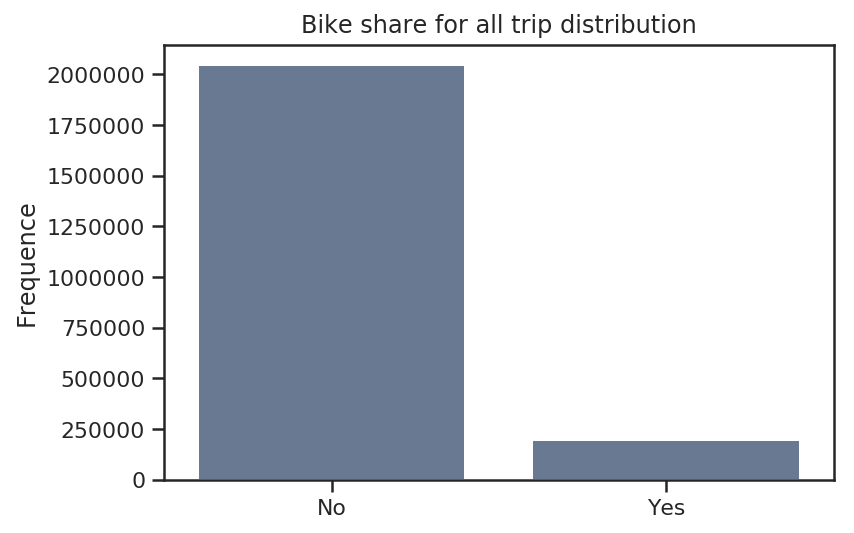

In [34]:
ax = sns.countplot(x='bike_share_for_all_trip', 
              data=bikeshare_df, 
              color='b', 
              saturation=0.4)

ax.set(xlabel='', ylabel='Frequence', title='Bike share for all trip distribution');

The distribution is quite distinct for the three categorical variables. 
Bike rentals is mostly done by a subscriber that is male and not part of the bike share for all trip.

Combining the tree categorical variables does it reveal any other pattern?

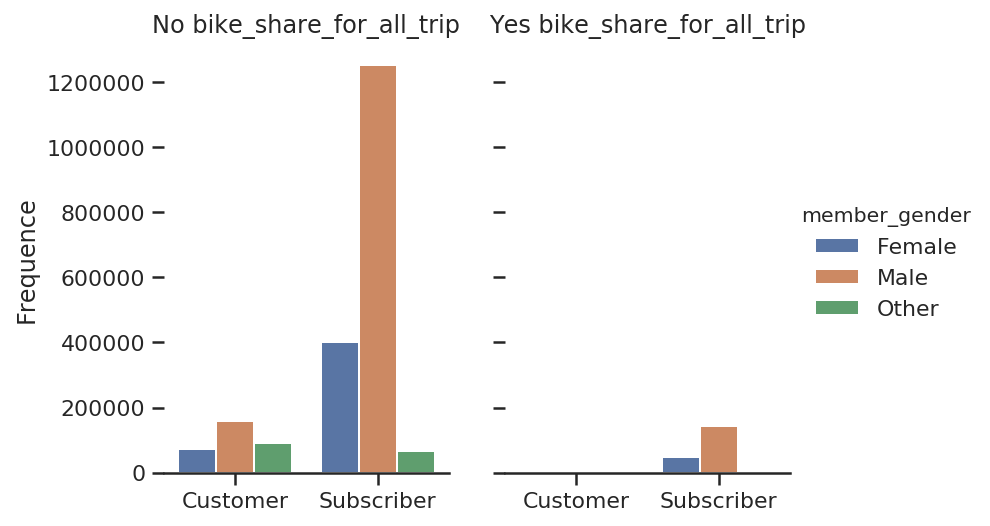

In [39]:
g = sns.catplot(x='user_type',
                hue='member_gender', 
                col='bike_share_for_all_trip', 
                data=bikeshare_df, 
                kind='count', 
                height=4, aspect=.7)


g.set_axis_labels("", "Frequence")\
    .set_xticklabels(["Customer", "Subscriber"])\
    .set_titles("{col_name} {col_var}")\
    .despine(left=True);

Reveals that bike share for all trip ...

AttributeError: 'AxesSubplot' object has no attribute 'set_ylabels'

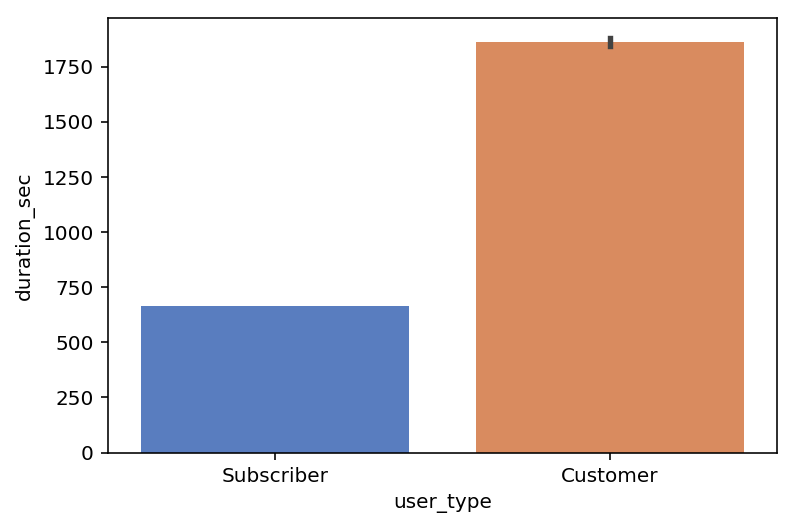

In [10]:
ax = sns.barplot(x='user_type', y='duration_sec', data=bikeshare_df, 
                    #hue='member_gender',
                    #kind='bar',
                palette='muted')
ax.set_ylabels('Rental duration (seconds)')

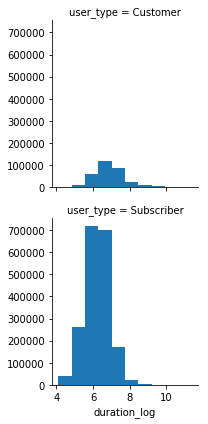

In [34]:
#g = sns.FacetGrid(bikeshare_df, col='user_type',  row='member_gender')
g = sns.FacetGrid(bikeshare_df, row='user_type')
g = g.map(plt.hist, 'duration_log')

In [36]:
# there is no correlation between bike_id and duration_sec
bikeshare_df[['duration_sec', 'bike_id']].corr()

,duration_sec,bike_id
duration_sec,1.00000,-0.00669
bike_id,-0.00669,1.00000


In [ ]:
from pandas.tools.plotting import scatter_matrix
fig, ax  = plt.subplots(figsize=(12, 12))
scatter_matrix(bikeshare_df, alpha=0.2, diagnonal='kde', ax=ax)

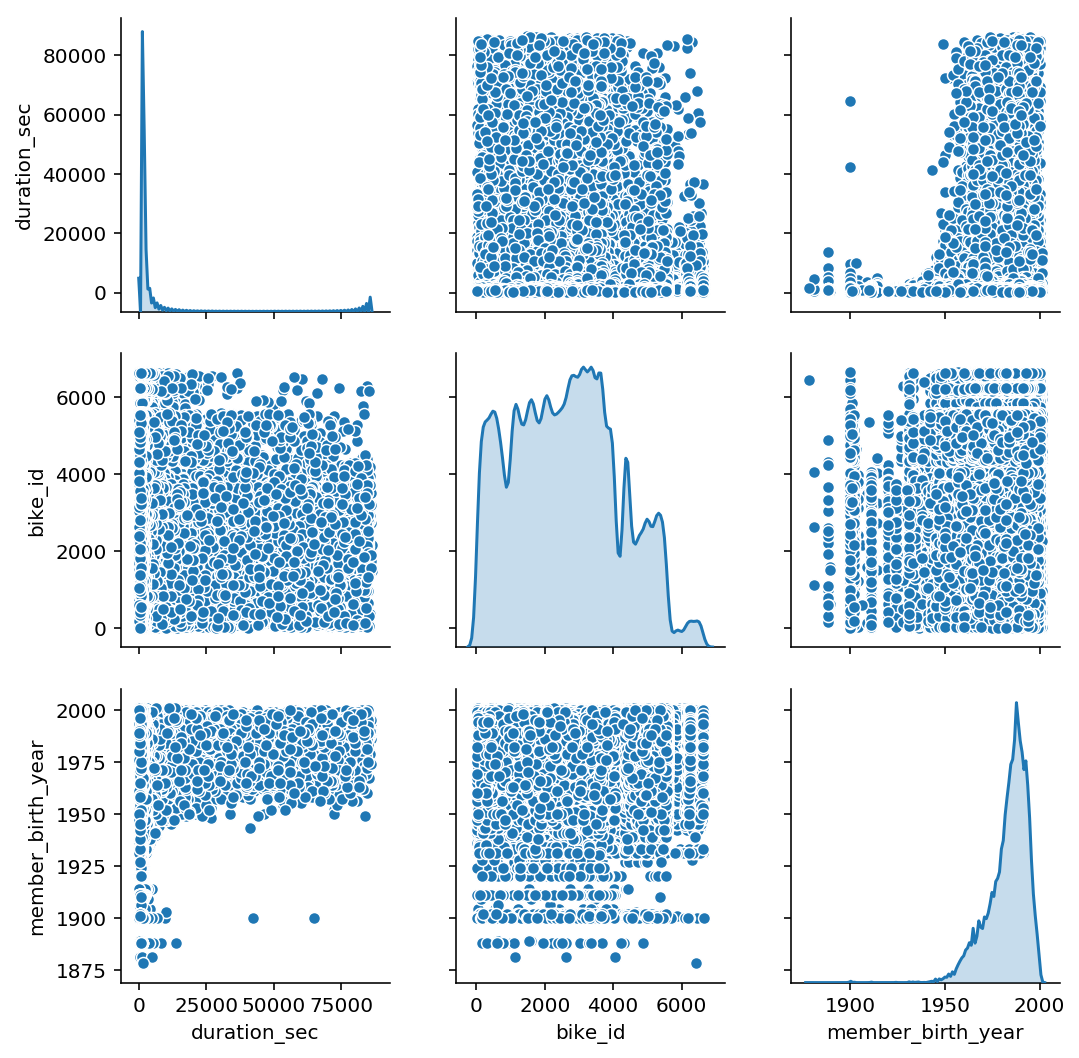

In [7]:
columns = ['duration_sec', 'bike_id', 'member_birth_year']
# hue='user_type'
sns.pairplot(bikeshare_df, vars=columns, diag_kind='kde')

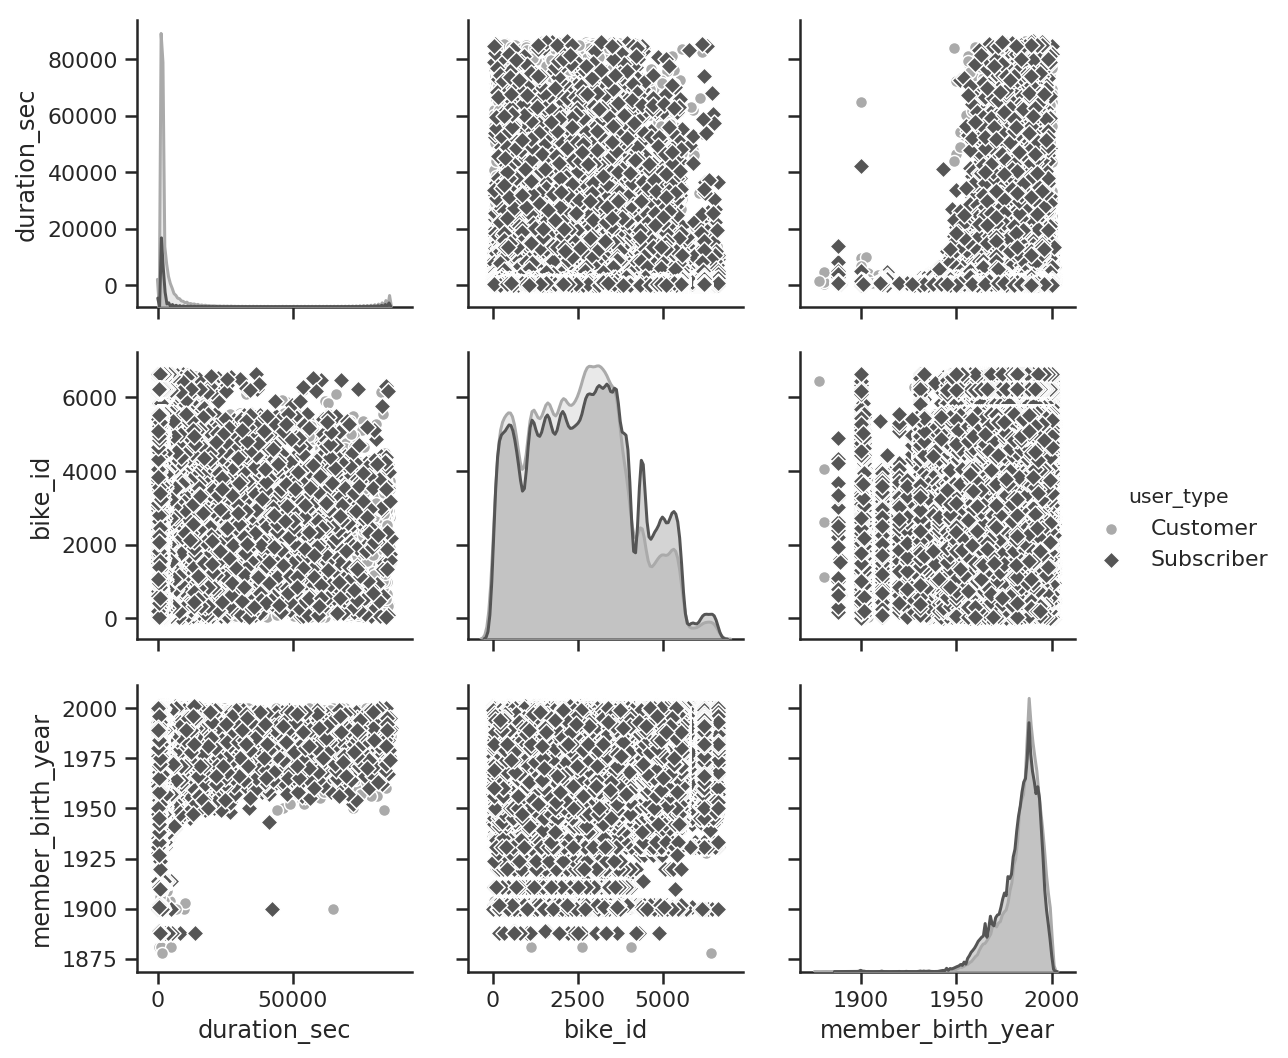

In [10]:
columns = ['duration_sec', 'bike_id', 'member_birth_year']
sns.pairplot(bikeshare_df, hue='user_type', palette='binary', markers=['o', 'D'], vars=columns, diag_kind='kde')

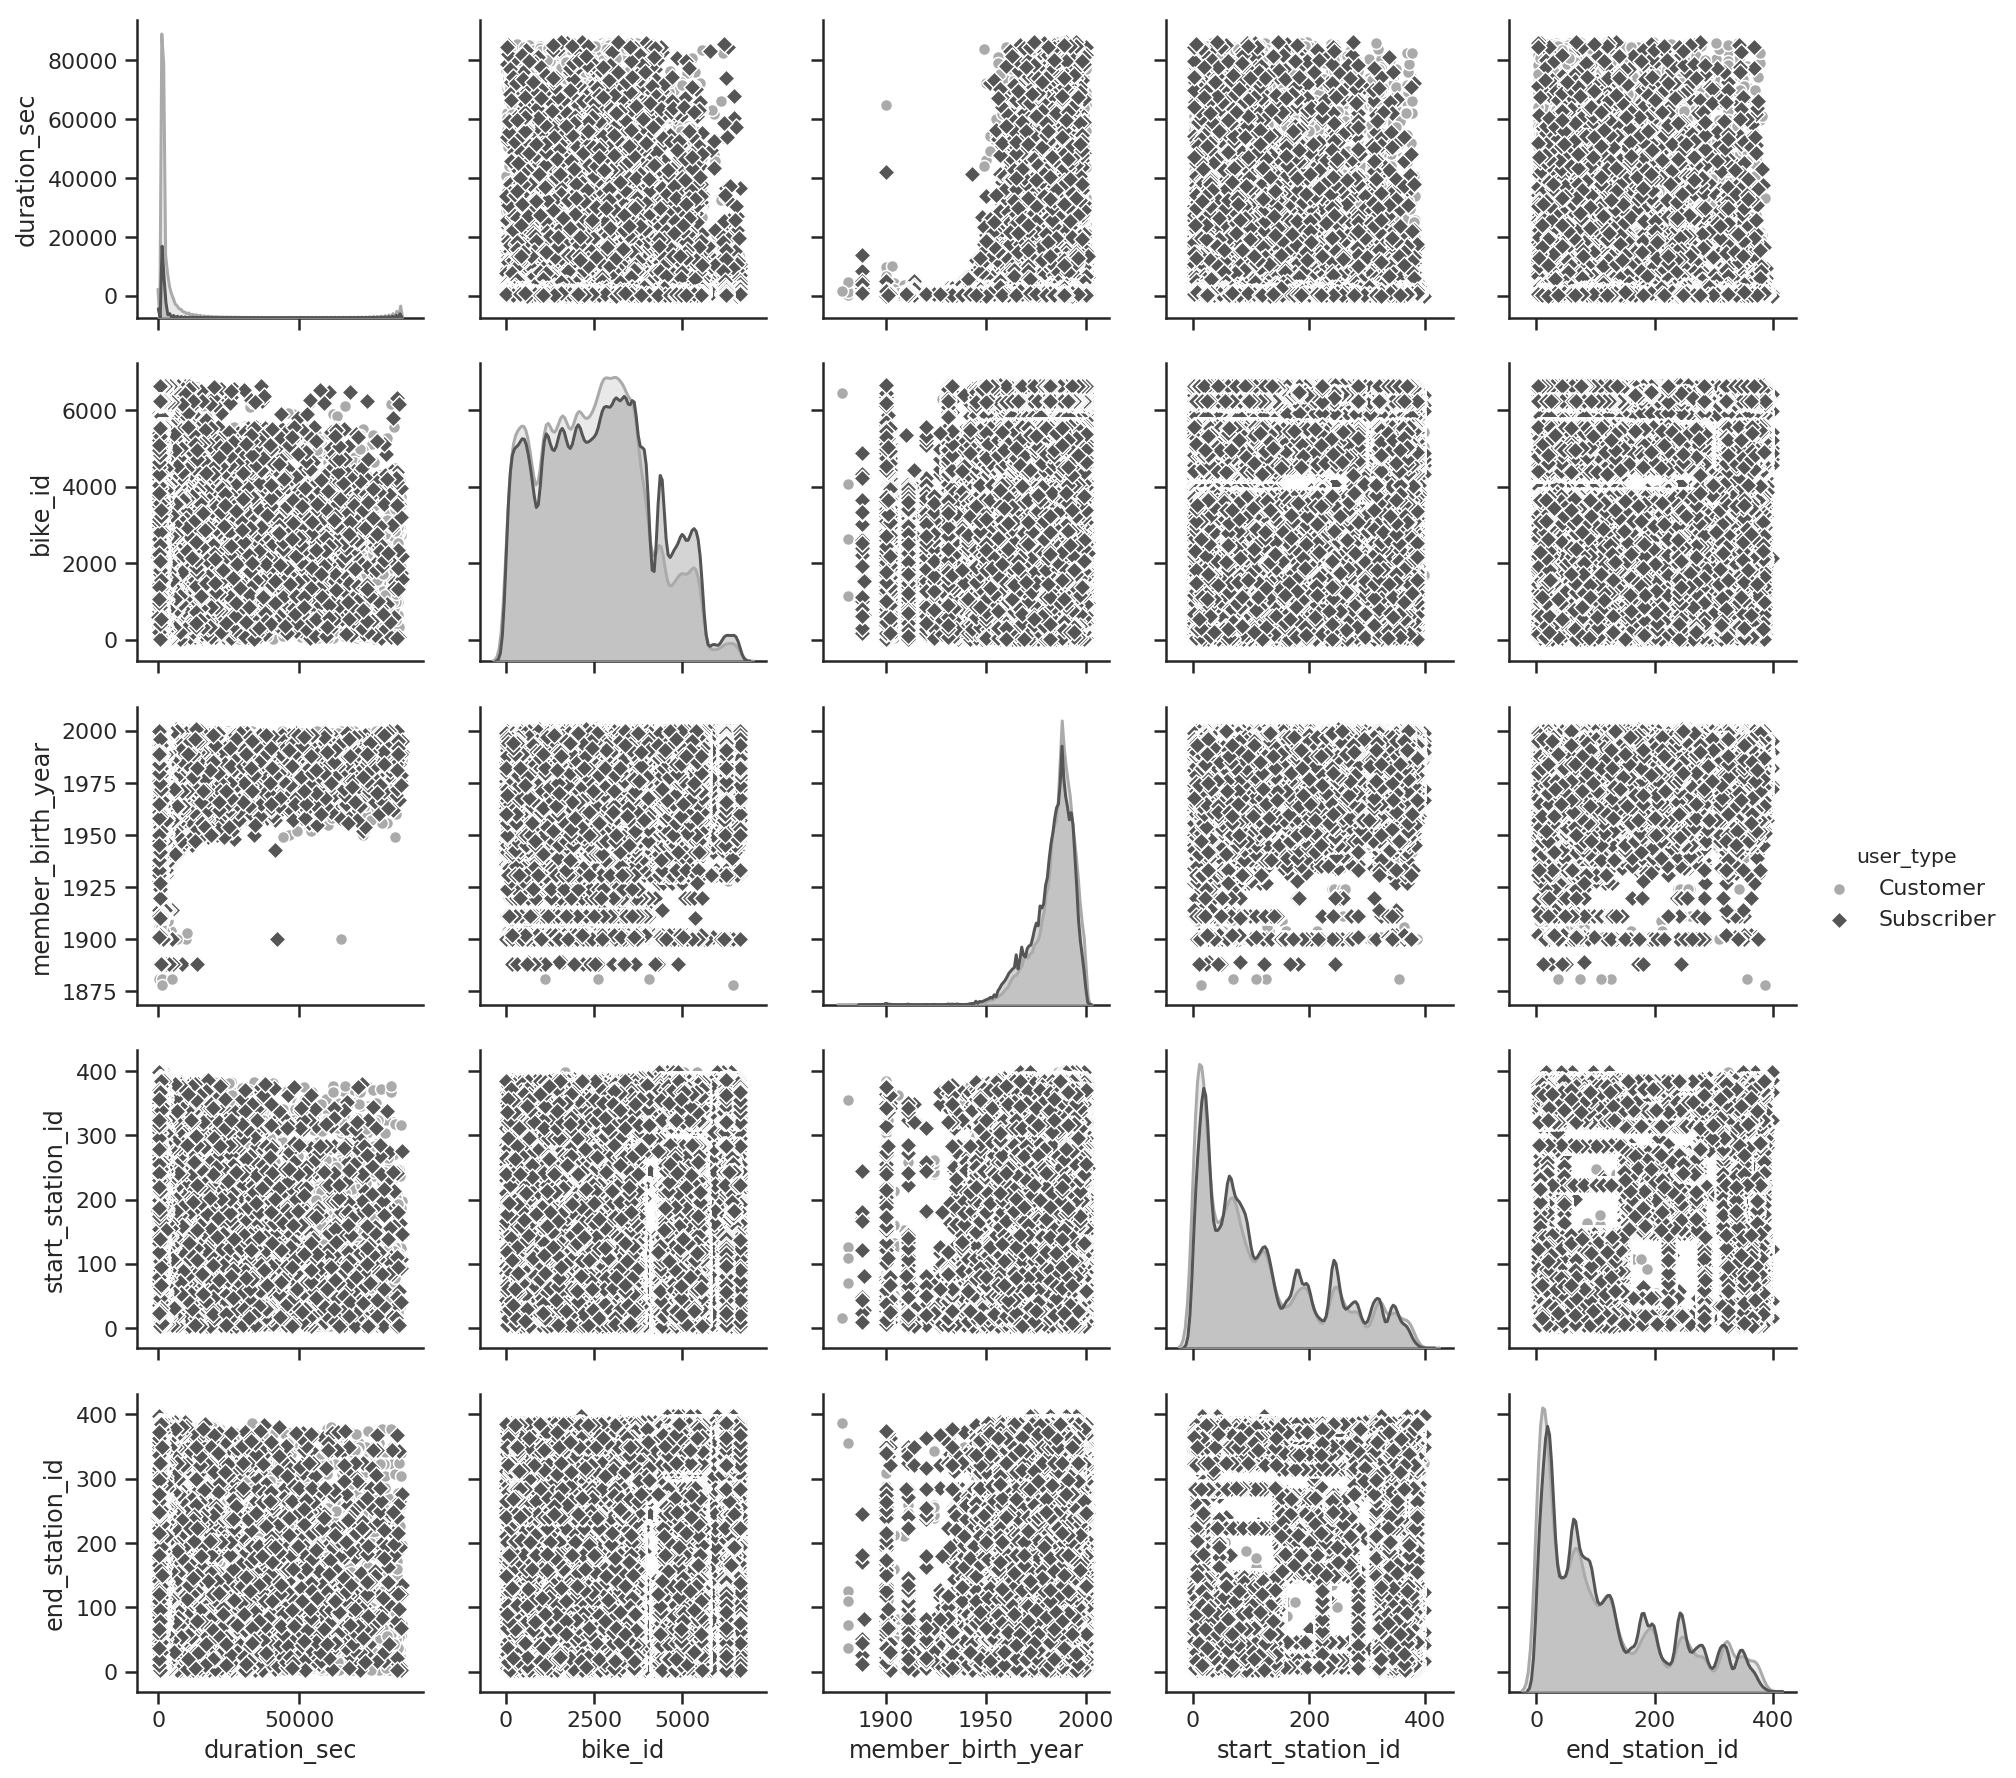

In [11]:
columns = ['duration_sec', 'bike_id', 'member_birth_year', 'start_station_id', 'end_station_id']
sns.pairplot(bikeshare_df, hue='user_type', palette='binary', markers=['o', 'D'], vars=columns, diag_kind='kde')

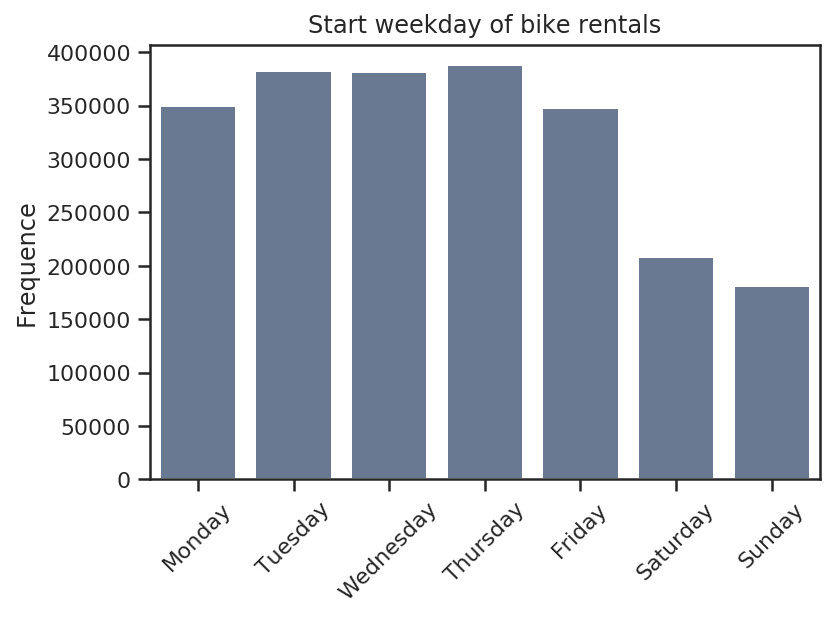

In [48]:
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

ax = sns.countplot(bikeshare_df.start_time.dt.weekday_name, 
                   order=weekday_names, 
                   color='b', 
                   saturation=0.4)

ax.set(xlabel='', 
       ylabel='Frequence', 
       title='Start weekday of bike rentals')
ax.tick_params(axis='x', 
               labelrotation=45)

In [109]:
userstart = bikeshare_df[['user_type', 'start_time', 'duration_sec']]
userstart['weekday'] = userstart.start_time.dt.weekday_name
#userstart.set_index('start_time', inplace=True)
#del userstart['start_time']

#userstart.head()
userstart.groupby(['weekday', 'user_type'])['duration_sec'].median()

/Users/marcusholmgren/code/pyvirtual/mlvenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


weekday    user_type 
Friday     Customer       885
           Subscriber     514
Monday     Customer       873
           Subscriber     509
Saturday   Customer      1132
           Subscriber     530
Sunday     Customer      1131
           Subscriber     518
Thursday   Customer       822
           Subscriber     509
Tuesday    Customer       824
           Subscriber     508
Wednesday  Customer       825
           Subscriber     510
Name: duration_sec, dtype: int64

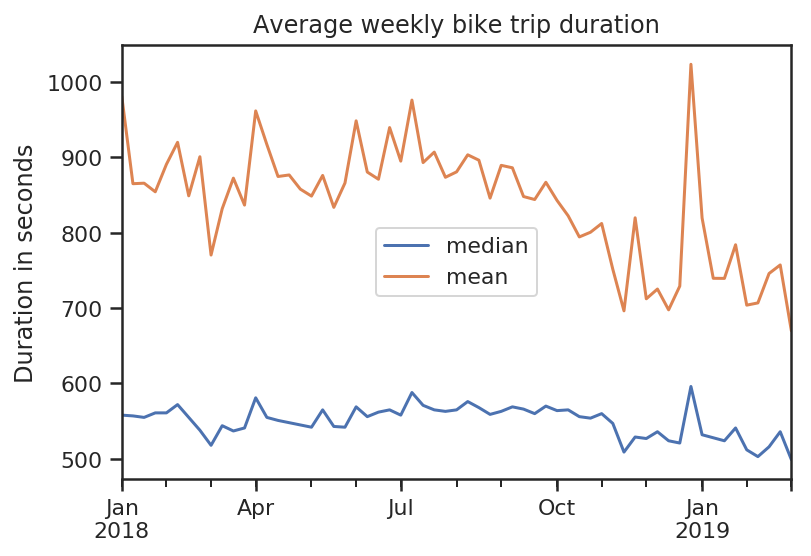

In [113]:
ax = userstart.resample('W', on='start_time')['duration_sec'].agg(['median', 'mean']).plot()
ax.set(xlabel='', ylabel='Duration in seconds', title='Average weekly bike trip duration');

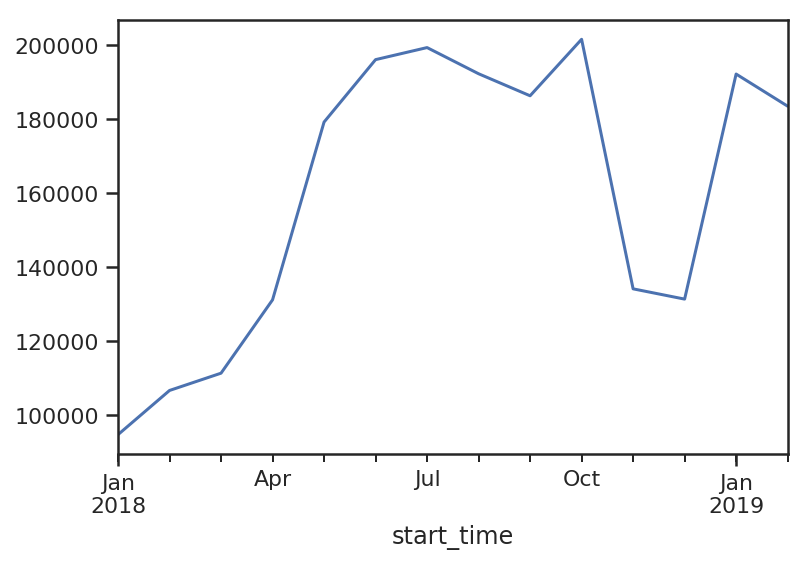

In [119]:
userstart.resample('M', on='start_time')['duration_sec'].count().plot();

The pairplot for user_type over duration_sec, bike_id, and member_birth_year is really busy. But there are some visual patterns that are interessting to perform further exploration on. 

In [ ]:
## Explainatory Data Analysis